In [148]:
from imports import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
warnings.filterwarnings("ignore")

#### Load data, split and create dataset

In [133]:
timeseries = process_file()
len(timeseries)

154

In [134]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [135]:
lookback=1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_test",X_test.shape, "y_test",y_test.shape)

X_train torch.Size([102, 1, 1]) y_train torch.Size([102, 1, 1])
X_test torch.Size([50, 1, 1]) y_test torch.Size([50, 1, 1])


In [161]:
from utils import scale_data
X_train, X_test, y_train, y_test = scale_data(X_train, X_test, y_train, y_test)

#### Defining LSTM Model and hyperparameters

In [162]:
from model import LSTMModel

model = LSTM()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=14, drop_last=True)

In [164]:
from model import train_model
train_loss, train_rmse = train_model(model, loader, optimizer, loss_fn, n_epochs=100, print_interval=10, seed=42)


Epoch 10/100, Train Loss: 0.2829,  Train RMSE: 0.0537
Epoch 20/100, Train Loss: 0.2567,  Train RMSE: 0.0512
Epoch 30/100, Train Loss: 0.2767,  Train RMSE: 0.0531
Epoch 40/100, Train Loss: 0.2609,  Train RMSE: 0.0516
Epoch 50/100, Train Loss: 0.2750,  Train RMSE: 0.0530
Epoch 60/100, Train Loss: 0.2643,  Train RMSE: 0.0519
Epoch 70/100, Train Loss: 0.2784,  Train RMSE: 0.0533
Epoch 80/100, Train Loss: 0.2733,  Train RMSE: 0.0528
Epoch 90/100, Train Loss: 0.2661,  Train RMSE: 0.0521
Epoch 100/100, Train Loss: 0.2758,  Train RMSE: 0.0531


#### Training nnet

In [140]:
torch.manual_seed(42)
np.random.seed(42)

train_loss = []
train_rmse = []

n_epochs = 100
print_interval = 10

for epoch in range(n_epochs):
    model.train()
    epoch_train_loss = 0.0
    epoch_train_rmse = 0.0
    num_samples = 0
    for X_batch, y_batch in loader:
        # forward pass
        y_pred = model(X_batch)

        # loss
        loss = loss_fn(y_pred, y_batch)
        epoch_train_loss += loss.item()

        # RMSE
        rmse = torch.sqrt(loss)
        epoch_train_rmse += rmse.item() ** 2
        num_samples += len(X_batch)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      # RMSE en cada epoch
    epoch_train_rmse = np.sqrt(epoch_train_rmse / num_samples)

    if (epoch + 1) % print_interval == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_train_loss:.4f},  Train RMSE: {epoch_train_rmse:.4f}")
    
    train_loss.append(epoch_train_loss)
    train_rmse.append(epoch_train_rmse)


Epoch 10/100, Train Loss: 0.2746,  Train RMSE: 0.0529
Epoch 20/100, Train Loss: 0.2555,  Train RMSE: 0.0511
Epoch 30/100, Train Loss: 0.2807,  Train RMSE: 0.0535
Epoch 40/100, Train Loss: 0.2598,  Train RMSE: 0.0515
Epoch 50/100, Train Loss: 0.2763,  Train RMSE: 0.0531
Epoch 60/100, Train Loss: 0.2656,  Train RMSE: 0.0521
Epoch 70/100, Train Loss: 0.2814,  Train RMSE: 0.0536
Epoch 80/100, Train Loss: 0.2748,  Train RMSE: 0.0530
Epoch 90/100, Train Loss: 0.2652,  Train RMSE: 0.0520
Epoch 100/100, Train Loss: 0.2780,  Train RMSE: 0.0533


#### Evaluating on train and test

In [141]:
train_preds = []
train_loss = []
test_loss = []
test_rmse = []
gradient_norm = []
test_preds = []

model.eval()

# disable gradient computation
with torch.no_grad():
        epoch_test_loss = 0.0
        epoch_test_rmse = 0.0 
    
        y_pred_train = model(X_train[:len(train)])
        y_pred_train_unscaled = scaler_y.inverse_transform(y_pred_train.detach().numpy().reshape(-1,1))
        train_preds.append(y_pred_train_unscaled)

        # mas de 1 feature
        #train_loss.append(loss_fn(y_pred_train[:, 0], y_train).item())
        #train_rmse.append(np.sqrt(loss_fn(y_pred_train[:, 0], y_train).item()))

        train_loss.append(loss_fn(y_pred_train, y_train).item())
        train_rmse.append(np.sqrt(loss_fn(y_pred_train, y_train).item()))
    
        y_pred_test = model(X_test[:len(test)])
        y_pred_test_unscaled = scaler_y.inverse_transform(y_pred_test.detach().numpy().reshape(-1,1))
        test_preds.append(y_pred_test_unscaled)

        # mas de 1 feature
        #test_loss.append(loss_fn(y_pred_test[:, 0], y_test).item()) 
        #test_rmse.append(np.sqrt(loss_fn(y_pred_test[:, 0], y_test).item()))

        test_loss.append(loss_fn(y_pred_test, y_test).item())
        test_rmse.append(np.sqrt(loss_fn(y_pred_test, y_test).item()))
    

In [142]:
# creo un array concatenando las predicciones
train_array = np.concatenate([tensor.flatten() for tensor in train_preds])
test_array = np.concatenate([tensor.flatten() for tensor in test_preds])
len(train_array), len(test_array)

(102, 50)

#### Plotting results

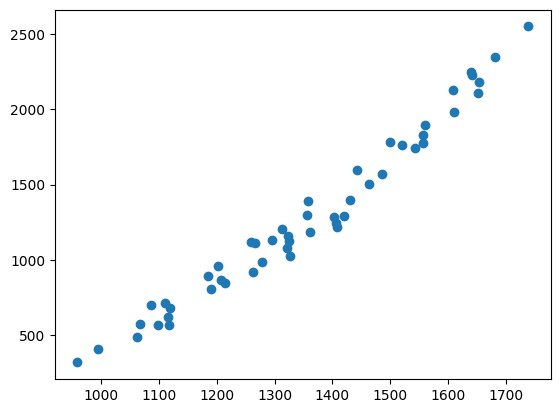

In [144]:
plt.scatter(test_array, test[:50])

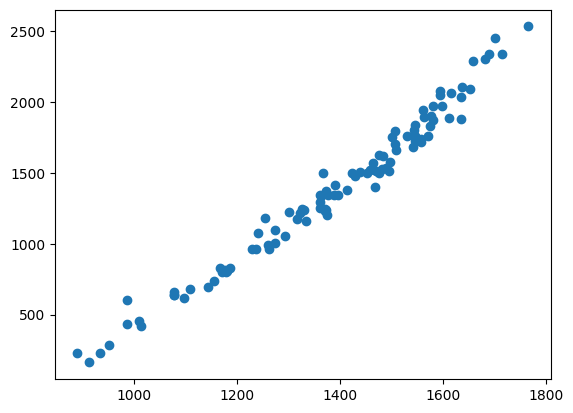

In [145]:
plt.scatter(train_array, train[:102])

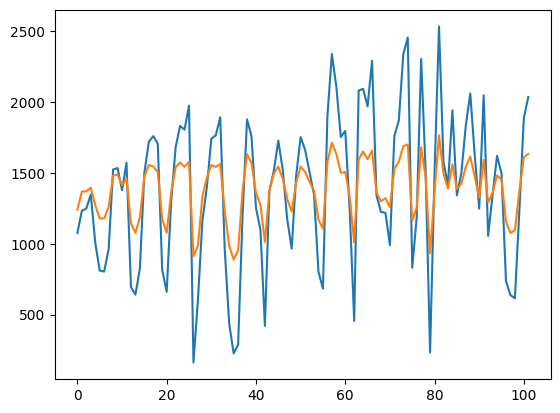

In [146]:
plt.plot(train[:102])
plt.plot(train_array)

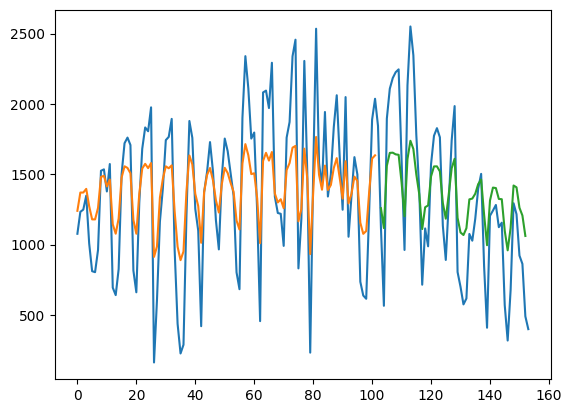

In [147]:
plt.plot(timeseries)
plt.plot(train_array)
plt.plot(range(103, 103+len(test_array)), test_array)

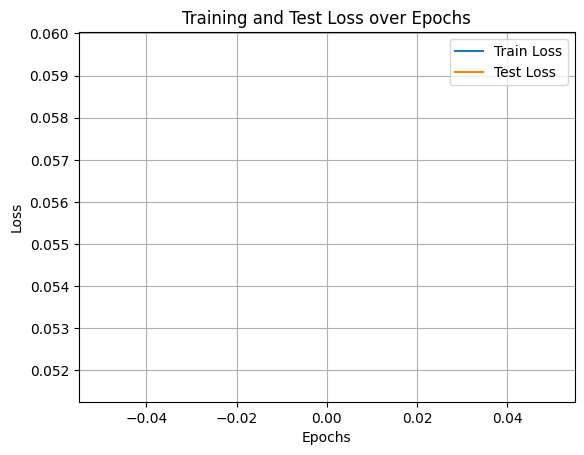

In [170]:
#epochs = range(0, n_epochs, 10)

#plt.plot(epochs, train_loss, label='Train Loss')
#plt.plot(epochs, test_loss, label='Test Loss')

plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')

plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()